['sweing' 'finishing']
['date', 'quarter', 'department', 'day', 'team', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers', 'actual_productivity']

Encoded Data:
   team  targeted_productivity    smv  over_time  incentive  idle_time  \
0     8                   0.80  26.16       7080         98        0.0   
1     1                   0.75   3.94        960          0        0.0   
2    11                   0.80  11.41       3660         50        0.0   
3    12                   0.80  11.41       3660         50        0.0   
4     6                   0.80  25.90       1920         50        0.0   

   idle_men  no_of_style_change  no_of_workers  actual_productivity  ...  \
0         0                   0           59.0             0.940725  ...   
1         0                   0            8.0             0.886500  ...   
2         0                   0           30.5             0.800570  ...   
3         0 

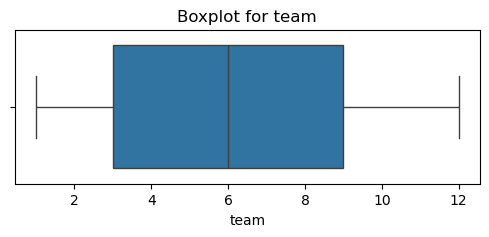

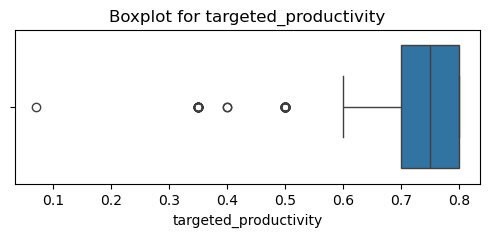

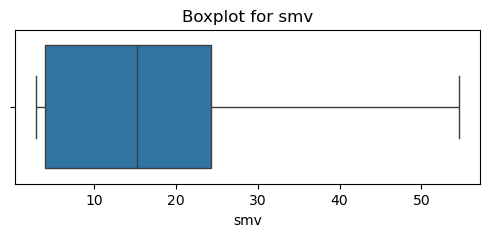

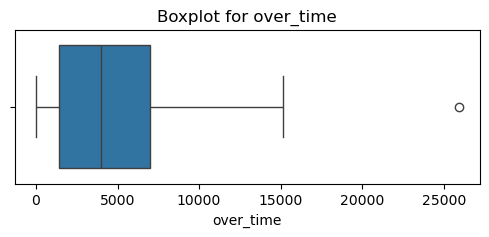

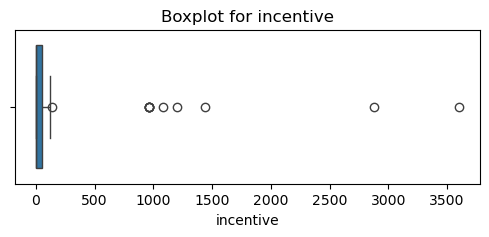

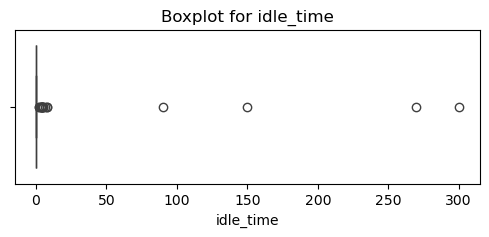

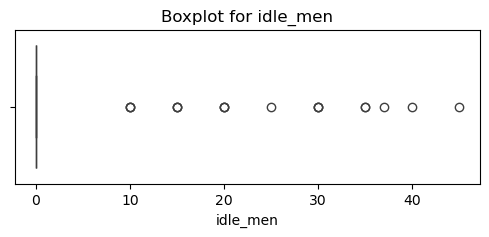

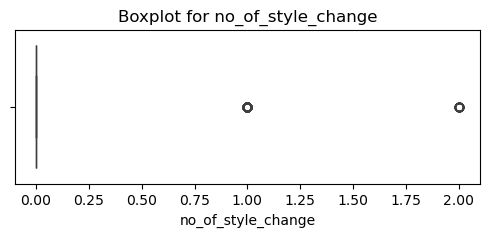

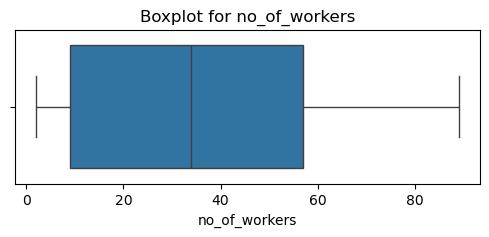

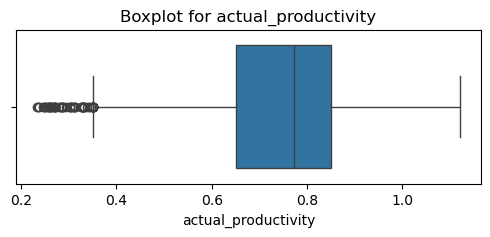


✅ Outliers handled using IQR method — values replaced with **median**.

Before OverSampling, counts of label 'Success': 608
Before OverSampling, counts of label 'Fail': 229
After OverSampling, counts of label 'Success': 608
After OverSampling, counts of label 'Fail': 608


In [1]:
import pandas as pd
file_path = r'C:\Users\ADMIN\Downloads\garments_worker_productivity.csv' 
df=pd.read_csv(file_path)
import matplotlib.pyplot as plt
import seaborn as sns
# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

df.head(5)
# Convert 'date' to datetime just in case
df['date'] = pd.to_datetime(df['date'])

# Extract month and day only (to compare mm-dd)
df['mmdd'] = df['date'].dt.strftime('%d-%m')

# Define custom quarters
def assign_custom_quarter(mmdd):
    if '01-01' <= mmdd <= '03-31':
        return 'Q1'
    elif '04-01' <= mmdd <= '06-30':
        return 'Q2'
    elif '07-01' <= mmdd <= '09-30':
        return 'Q3'
    else:
        return 'Q4'

# Apply function to every row
df['quarter'] = df['mmdd'].apply(assign_custom_quarter)

# Optional: Drop mmdd helper column
df.drop(columns=['mmdd'], inplace=True)



# Remove leading/trailing spaces in the 'department' column
df['department'] = df['department'].str.strip()

# Get unique values after cleaning
unique_departments = df['department'].unique()

print(unique_departments)
print(df.columns.tolist())
df.drop(['wip'],axis=1 ,inplace =True)
from sklearn.preprocessing import LabelEncoder

# Create 'success' column
df['success'] = df['actual_productivity'] > df['targeted_productivity']
df['success'] = df['success'].apply(lambda x: 'Success' if x else 'Fail')
# Convert categorical variables to numerical values using one-hot encoding
df = df.drop(columns=['date'])
data_encoded = pd.get_dummies(df, columns=['quarter', 'department', 'day'])
print("\nEncoded Data:")
print(data_encoded.head())
from sklearn.preprocessing import MinMaxScaler

# Step 1: Identify numerical columns
numerical_features = ['team', 'targeted_productivity', 'smv','over_time','incentive',
                      'idle_time','idle_men','no_of_style_change', 'no_of_workers', 'actual_productivity']

# Step 2: Visualize outliers using boxplots (optional)
import seaborn as sns
import matplotlib.pyplot as plt

for feature in numerical_features:
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=data_encoded[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

# Step 3: Apply IQR and replace outliers with median
for feature in numerical_features:
    Q1 = data_encoded[feature].quantile(0.25)
    Q3 = data_encoded[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    median_val = data_encoded[feature].median()
    
    # Replace outliers with median
    data_encoded[feature] = data_encoded[feature].apply(
        lambda x: median_val if x < lower_bound or x > upper_bound else x
    )

print("\n✅ Outliers handled using IQR method — values replaced with **median**.\n")
# Split features and target
X = data_encoded.drop(columns=['success'])
y = data_encoded['success']

# Encode target
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

print("Before OverSampling, counts of label 'Success':", sum(y_train == 1))
print("Before OverSampling, counts of label 'Fail':", sum(y_train == 0))
from imblearn.over_sampling import SMOTE
# Apply SMOTE to the training data
sm = SMOTE(random_state=2)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train.ravel())

# Display class distribution after SMOTE
print("After OverSampling, counts of label 'Success': {}".format(sum(y_train_smote == 1)))
print("After OverSampling, counts of label 'Fail': {}".format(sum(y_train_smote == 0)))

In [2]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import time

def decision_tree_before_tuning(X_train_smote, y_train_smote, X_test, y_test):
    # Start timer
    start_time = time.time()
    
    # Default decision tree
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train_smote, y_train_smote)

    end_time = time.time()
    print(f"Training time: {end_time - start_time:.4f} seconds")

    # Predictions
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, cmap=plt.cm.Blues)
    plt.title("Decision Tree - Before Tuning")
    plt.show()

    return fpr, tpr, roc_auc, clf


In [7]:
from sklearn.model_selection import GridSearchCV

def decision_tree_after_tuning(X_train_smote, y_train_smote, X_test, y_test):
    # Parameter grid
    param_grid = {
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }

    grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

    # Start timer
    start_time = time.time()
    grid.fit(X_train_smote, y_train_smote)
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.4f} seconds")
    print("Best parameters:", grid.best_params_)

    best_clf = grid.best_estimator_

    # Predictions
    y_pred = best_clf.predict(X_test)
    y_prob = best_clf.predict_proba(X_test)[:, 1]

    # Evaluation
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # ROC + AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    print(fpr)
    print(tpr)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # Plot Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(best_clf, X_test, y_test, cmap=plt.cm.Blues)
    plt.title("Decision Tree - After Tuning")
    plt.show()

    return fpr, tpr, roc_auc, best_clf


Training time: 0.0165 seconds
Accuracy: 0.9527777777777777
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.91        99
           1       0.97      0.97      0.97       261

    accuracy                           0.95       360
   macro avg       0.94      0.94      0.94       360
weighted avg       0.95      0.95      0.95       360

Confusion Matrix:
 [[ 91   8]
 [  9 252]]
AUC: 0.9424


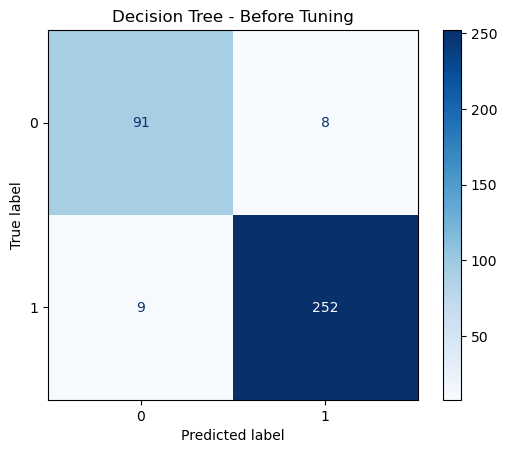

Training time: 6.9871 seconds
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91        99
           1       0.97      0.96      0.97       261

    accuracy                           0.95       360
   macro avg       0.93      0.94      0.94       360
weighted avg       0.95      0.95      0.95       360

Confusion Matrix:
 [[ 92   7]
 [ 11 250]]
[0.         0.06060606 0.07070707 0.09090909 0.11111111 1.        ]
[0.         0.95019157 0.95785441 0.97701149 0.98084291 1.        ]
AUC: 0.9581


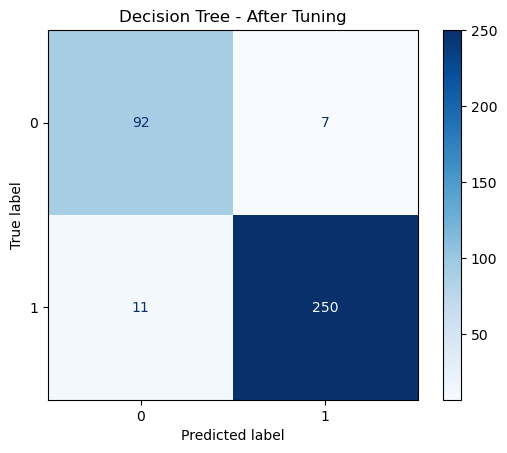

In [8]:
fpr, tpr, roc_auc, clf= decision_tree_before_tuning(X_train_smote, y_train_smote, X_test, y_test)
fpr, tpr, roc_auc, best_clf = decision_tree_after_tuning(X_train_smote, y_train_smote, X_test, y_test)

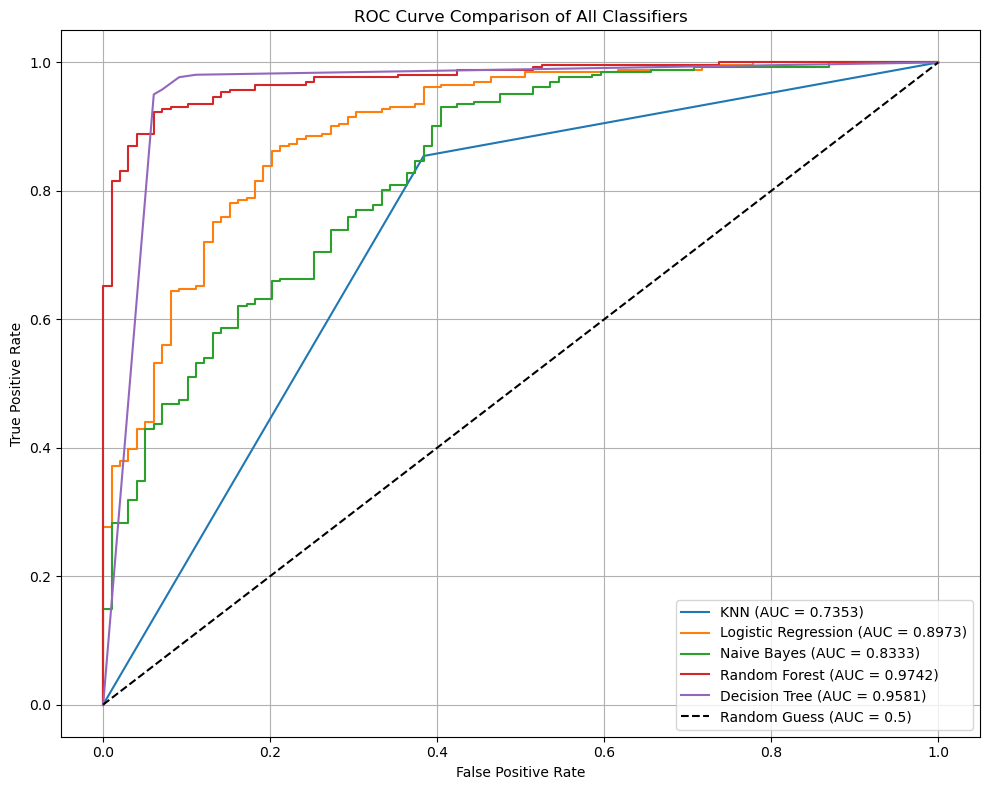

In [10]:
import matplotlib.pyplot as plt
# KNN
fpr_knn = [0.0, 0.38383838, 1.0]
tpr_knn = [0.0, 0.85440613, 1.0]
auc_knn = 0.7352838732149077

# Logistic Regression (LR)
fpr_lr = [
    0.0, 0.0, 0.0, 0.01010101, 0.01010101, 0.02020202,
    0.02020202, 0.03030303, 0.03030303, 0.04040404, 0.04040404, 0.05050505,
    0.05050505, 0.06060606, 0.06060606, 0.07070707, 0.07070707, 0.08080808,
    0.08080808, 0.09090909, 0.09090909, 0.11111111, 0.11111111, 0.12121212,
    0.12121212, 0.13131313, 0.13131313, 0.14141414, 0.14141414, 0.15151515,
    0.15151515, 0.16161616, 0.16161616, 0.17171717, 0.17171717, 0.18181818,
    0.18181818, 0.19191919, 0.19191919, 0.2020202, 0.2020202, 0.21212121,
    0.21212121, 0.22222222, 0.22222222, 0.23232323, 0.23232323, 0.24242424,
    0.24242424, 0.26262626, 0.26262626, 0.27272727, 0.27272727, 0.28282828,
    0.28282828, 0.29292929, 0.29292929, 0.3030303, 0.3030303, 0.33333333,
    0.33333333, 0.34343434, 0.34343434, 0.37373737, 0.37373737, 0.38383838,
    0.38383838, 0.4040404, 0.4040404, 0.44444444, 0.44444444, 0.46464646,
    0.46464646, 0.50505051, 0.50505051, 0.61616162, 0.61616162, 0.71717172,
    0.71717172, 0.72727273, 0.72727273, 0.77777778, 0.77777778, 1.0
]
tpr_lr = [
    0.0, 0.00383142, 0.27586207, 0.27586207, 0.37164751, 0.37164751,
    0.37931034, 0.37931034, 0.39846743, 0.39846743, 0.42911877, 0.42911877,
    0.44061303, 0.44061303, 0.53256705, 0.53256705, 0.55938697, 0.55938697,
    0.64367816, 0.64367816, 0.64750958, 0.64750958, 0.651341, 0.651341,
    0.72030651, 0.72030651, 0.75095785, 0.75095785, 0.75862069, 0.75862069,
    0.7816092, 0.7816092, 0.78544061, 0.78544061, 0.78927203, 0.78927203,
    0.81609195, 0.81609195, 0.83908046, 0.83908046, 0.86206897, 0.86206897,
    0.8697318, 0.8697318, 0.87356322, 0.87356322, 0.88122605, 0.88122605,
    0.88505747, 0.88505747, 0.88888889, 0.88888889, 0.90038314, 0.90038314,
    0.90421456, 0.90421456, 0.91570881, 0.91570881, 0.92337165, 0.92337165,
    0.92720307, 0.92720307, 0.93103448, 0.93103448, 0.9348659, 0.9348659,
    0.96168582, 0.96168582, 0.96551724, 0.96551724, 0.96934866, 0.96934866,
    0.97701149, 0.97701149, 0.98467433, 0.98467433, 0.98850575, 0.98850575,
    0.99233716, 0.99233716, 0.99616858, 0.99616858, 1.0, 1.0
]
auc_lr = 0.8973

# Naive Bayes
fpr_nb = [
    0.0, 0.0, 0.0, 0.01010101, 0.01010101, 0.03030303, 0.03030303, 0.04040404,
    0.04040404, 0.05050505, 0.05050505, 0.06060606, 0.06060606, 0.07070707,
    0.07070707, 0.09090909, 0.09090909, 0.1010101, 0.1010101, 0.11111111,
    0.11111111, 0.12121212, 0.12121212, 0.13131313, 0.13131313, 0.14141414,
    0.14141414, 0.16161616, 0.16161616, 0.17171717, 0.17171717, 0.18181818,
    0.18181818, 0.2020202, 0.2020202, 0.21212121, 0.21212121, 0.25252525,
    0.25252525, 0.27272727, 0.27272727, 0.29292929, 0.29292929, 0.3030303,
    0.3030303, 0.32323232, 0.32323232, 0.33333333, 0.33333333, 0.34343434,
    0.34343434, 0.36363636, 0.36363636, 0.37373737, 0.37373737, 0.38383838,
    0.38383838, 0.39393939, 0.39393939, 0.4040404, 0.4040404, 0.42424242,
    0.42424242, 0.44444444, 0.44444444, 0.47474747, 0.47474747, 0.51515152,
    0.51515152, 0.53535354, 0.53535354, 0.54545455, 0.54545455, 0.58585859,
    0.58585859, 0.5959596, 0.5959596, 0.65656566, 0.65656566, 0.70707071,
    0.70707071, 0.86868687, 0.86868687, 1.0
]

tpr_nb = [
    0.0, 0.03065134, 0.14942529, 0.14942529, 0.2835249, 0.2835249, 0.31800766,
    0.31800766, 0.348659, 0.348659, 0.42911877, 0.42911877, 0.43678161,
    0.43678161, 0.46743295, 0.46743295, 0.47509579, 0.47509579, 0.50957854,
    0.50957854, 0.53256705, 0.53256705, 0.54022989, 0.54022989, 0.57854406,
    0.57854406, 0.5862069, 0.5862069, 0.62068966, 0.62068966, 0.62452107,
    0.62452107, 0.63218391, 0.63218391, 0.65900383, 0.65900383, 0.66283525,
    0.66283525, 0.70498084, 0.70498084, 0.7394636, 0.7394636, 0.75862069,
    0.75862069, 0.77011494, 0.77011494, 0.77777778, 0.77777778, 0.80076628,
    0.80076628, 0.80842912, 0.80842912, 0.82758621, 0.82758621, 0.8467433,
    0.8467433, 0.8697318, 0.8697318, 0.90038314, 0.90038314, 0.93103448,
    0.93103448, 0.9348659, 0.9348659, 0.93869732, 0.93869732, 0.95019157,
    0.95019157, 0.96168582, 0.96168582, 0.96934866, 0.96934866, 0.97701149,
    0.97701149, 0.98084291, 0.98084291, 0.98467433, 0.98467433, 0.98850575,
    0.98850575, 0.99233716, 0.99233716, 1.0, 1.0
]

auc_nb = 0.83331398273927

# --- Random Forest (After tuning) ---
fpr_rf = [0.0, 0.0, 0.0, 0.0, 0.0, 0.01010101, 0.01010101, 0.02020202, 0.02020202, 0.03030303, 0.03030303,
          0.04040404, 0.04040404, 0.06060606, 0.06060606, 0.07070707, 0.07070707, 0.08080808, 0.08080808,
          0.1010101, 0.1010101, 0.13131313, 0.13131313, 0.14141414, 0.14141414, 0.15151515, 0.15151515,
          0.18181818, 0.18181818, 0.24242424, 0.24242424, 0.25252525, 0.25252525, 0.35353535, 0.35353535,
          0.42424242, 0.42424242, 0.51515152, 0.51515152, 0.52525253, 0.52525253, 0.73737374, 0.73737374, 1.0]

tpr_rf = [0.0, 0.00383142, 0.16858238, 0.17624521, 0.651341, 0.651341, 0.81609195, 0.81609195, 0.83141762,
          0.83141762, 0.8697318, 0.8697318, 0.88888889, 0.88888889, 0.92337165, 0.92337165, 0.92720307,
          0.92720307, 0.93103448, 0.93103448, 0.9348659, 0.9348659, 0.94636015, 0.94636015, 0.95402299,
          0.95402299, 0.95785441, 0.95785441, 0.96551724, 0.96551724, 0.96934866, 0.96934866, 0.97701149,
          0.97701149, 0.98084291, 0.98084291, 0.98850575, 0.98850575, 0.99233716, 0.99233716, 0.99616858,
          0.99616858, 1.0, 1.0]

auc_rf = 0.9742

# --- Decision Tree (After tuning) ---
fpr_dt = [0.0, 0.06060606, 0.07070707, 0.09090909, 0.11111111, 1.0]
tpr_dt = [0.0, 0.95019157, 0.95785441, 0.97701149, 0.98084291, 1.0]
auc_dt = 0.9581
# Plot settings
plt.figure(figsize=(10, 8))

# Plot ROC curves
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.4f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {auc_nb:.4f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})')

# Plot diagonal line (baseline for random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of All Classifiers')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()